In [1]:
from mantaray.core import single_ray
from supporting_functions import c_and_cg_calc, c_deep, c_shallow
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

### General Functions

In [2]:
def snells_law_bathymetry(phi, old_c, new_c):
    '''
    Snell's Law for ray incident on shear v current boundary (specifically passing from zero current region
    to non-zero v current region)
    Args:
        phi (float): Angle relative to x axis of ray incident on boundary
        old_c (float): Phase speed of ray incident on boundary
        new_c (float): Phase speed of transmitted ray
    Returns:
        new_phi (float): Angle relative to x axis of transmitted ray
    '''
    return np.arcsin(np.sin(phi)*new_c/old_c)

def snells_law_shear_current(phi, old_c, v):
    '''
    Snell's Law for ray incident on shear v current boundary (specifically passing from zero current region
    to non-zero v current region)
    Args:
        phi (float): Angle relative to x axis of ray incident on boundary
        old_c (float): Phase speed of ray incident on boundary
        v (float): v current velocity on transmission side of interface
    Returns:
        new_phi (float): Angle relative to x axis of transmitted ray
    '''
    return np.arcsin(np.sin(phi) / (1- v/old_c*np.sin(phi))**2)

def analytical_ray_trace(xs, y0, phi0, k0, mode='shallow_bathymetry', depths=None, v_currents=None):
    '''
    Analytically trace ray at angle phi0 from x axis with wavenumber k0, through points xs. 
    Assumes that medium changes are a function of x only (invariant in y, such that k_y is a constant).
    Args:
        xs (np.array): Array of x coordinates to trace through (each x corresponds to a change in the medium)
        y0 (float): Initial y value of ray (corresponding to xs[0])
        phi0 (float): Initial angle from x axis of ray in radians
        k0 (float): Initial wavenumber of the ray
        mode (str): Select which version of snell's law is used to compute refraction, and how to calculate phase
            speed and group velocity (deep or shallow water approximation).
            - Options:
                - 'shallow_bathymetry': Refraction in shallow water due to bathymetry, neglecting currents. Uses shallow
                    water approximation.
                - 'shear_currents': Refraction in deep water due to shear v current boundary (u currents assumed to be 0).
                    Uses deep water approximation.
        depths (np.array): Array of depths. Each value corresponds to a space between 2 subsequent xs coordinates,
            so depths should have length = len(xs)-1. If not provided, uniform depths of 10,000 m are used.
        v_currents (np.array): Array of v direction currents. Each value corresponds to a space between 2 subsequent
            xs coordinates, so v_currents should have length = len(xs)-1. If not provided, zero current field is used.
    Returns:
        ys (np.array): Array of ray y values corresponding to provided x values in xs
        phis (np.array): Array of ray angles. Each value corresponds to a space between subsequent xs coordinates, so
            len(phis) = len(xs)-1.
        ks (np.array): Array of ray wavenumber values. Each value corresponds to a space between subsequent xs
            coordinates, so len(ks) = len(xs)-1
    '''
    # Initialize Arrays for phis and ys with len = 1 less than xs (don't need final point)
    phis = np.ones(shape=len(xs)-1)
    phis[0] = phi0
    ks = np.ones(shape=len(xs)-1)
    ks[0] = k0
    ky0 = k0 * np.sin(phi0)
    cs = np.ones(shape=len(xs)-1)
    ys = np.ones(shape=len(xs))
    ys[0] = y0

    # If no currents provided, initialize array of 0s
    if v_currents is None:
        v_currents = np.zeros(shape=len(xs)-1)
    
    # If no depth provided, assume deep water flat bathymetry
    if depths is None:
        depths = np.ones(shape=len(xs)-1)*10000

    # Set mode for computing refraction and wave speed
    snells_law_func_dict = {'shallow_bathymetry':snells_law_bathymetry, 'shear_currents':snells_law_shear_current}
    snells_law_func = snells_law_func_dict[mode]

    # Compute initial phase speed, group velocity using dispersion relationship
    cs[0], cg = c_and_cg_calc(depths[0], ks[0]) # group velocity not stored in array, but as single updated value

    #Iterate over each xs aside from last 2, computing phi then ys for next value
    for i, x, in enumerate(xs[:-2]):

        # If shallow water bathymetry, compute transmitance phase speed (needed to compute refraction with snell's law)
        if mode == 'shallow_bathymetry':
            # Use shallow water approximation to calculate new phase speed, group velocity
            cs[i+1] = c_shallow(depths[i+1])
            cg = cs[i+1]
        # Compute new phi
        snells_law_args_dict = {'shallow_bathymetry':{'phi':phis[i], 'old_c':cs[i], 'new_c':cs[i+1]},
                           'shear_currents':{'phi':phis[i], 'old_c':cs[i], 'v':v_currents[i+1]}}
        snells_law_args = snells_law_args_dict[mode]
        phis[i+1] = snells_law_func(**snells_law_args)

        # Compute new k
        ks[i+1] = ky0 / np.sin(phis[i+1])

        # If deep shear currents, calculate phase speed (needed new wavenumber from snell's law first)
        if mode == 'shear_currents':
            # Use deep water approximation to calculate new phase speed, group velocity
            cs[i+1] = c_deep(ks[i+1])
            cg = cs[i+1] * 0.5

        # Compute new y value for ray
        ys[i+1] = ys[i] + (np.tan(phis[i]) + v_currents[i] / (cg * np.cos(phis[i]))) * (xs[i+1] - xs[i])
    
    # Compute final y value
    ys[-1] = ys[-2] + (np.tan(phis[-1]) + v_currents[-1] / (cg * np.cos(phis[-1]))) * (xs[-1] - xs[-2])

    return phis, ys, ks

## Step Function Bathymetry

### Import and Verify Data

Text(0.5, 1.0, 'V Current')

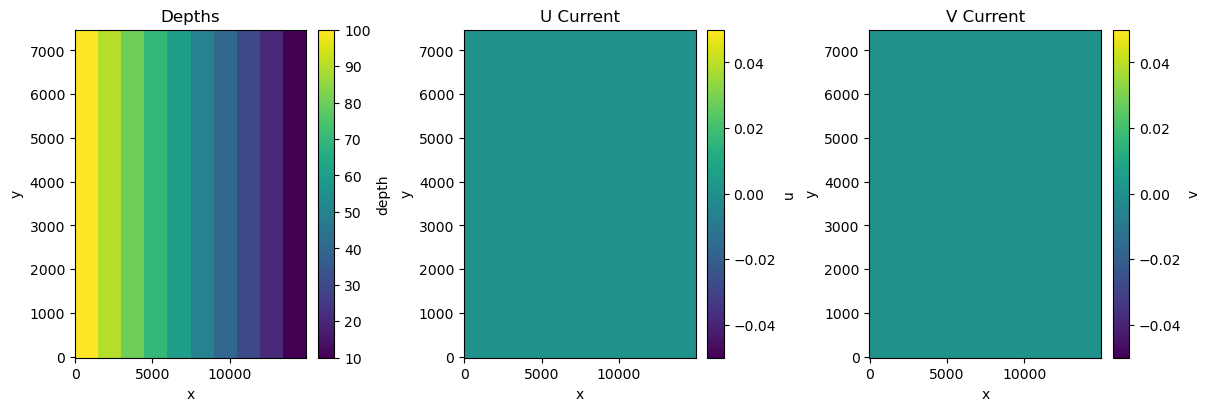

In [3]:
step_bathymetry_path = 'data/step_bathymetry.nc'
null_current_path = 'data/null_current.nc'
step_bathymetry = xr.open_dataset(step_bathymetry_path)
null_current = xr.open_dataset(null_current_path)

# Plot Data to Verify
fig, ax_list = plt.subplots(1, 3, figsize=(12,4), layout='constrained')
step_bathymetry.depth.plot(ax=ax_list[0])
null_current.u.plot(ax=ax_list[1])
null_current.v.plot(ax=ax_list[2])
ax_list[0].set_title('Depths')
ax_list[1].set_title('U Current')
ax_list[2].set_title('V Current')

### Define Ray and Run Ray Trace

In [4]:
# Define Environment Parameters
depth_max = step_bathymetry.depth.max().values
NY, NX = step_bathymetry.depth.shape
dl = np.diff(step_bathymetry.x.values)[0]
depth_levels_raw, depth_indices_raw = np.unique(step_bathymetry.depth.values, return_index=True)
depth_levels = np.flip(depth_levels_raw)
depth_indices = np.flip(depth_indices_raw)
n_shelfs = len(depth_levels)

# Define wave Parameters
k = 2*np.pi/10000 # lambda = 10000m
phi0 = np.pi/8
kx = k*np.cos(phi0)
ky = k*np.sin(phi0)
omega = np.sqrt(depth_max*9.8)*k

# Define ray initial positon
x0 = 50 # Offset from 0 by 1 step
y0 = 500

In [5]:
# Run Single Ray Trace with bathymetry and null current developed above
ray_evolution_raw = single_ray(x0, y0, kx, ky, 1000, 0.5,
                           bathymetry='data/step_bathymetry.nc',
                           current='data/null_current.nc')
# Process ray trace dataset to add wavenumber magnitude and angle information
ray_evolution = ray_evolution_raw.assign(k = np.sqrt(ray_evolution_raw.kx**2 + ray_evolution_raw.ky**2),
                                         phi = np.arctan2(ray_evolution_raw.ky, ray_evolution_raw.kx))

### Analytically Solve for Ray Path

In [6]:
cs = np.sqrt(9.8*depth_levels)
# Pick x values corresponding to the different boundaries
shelf_edge_xs = step_bathymetry.x.values[depth_indices]
xs_analytical = np.append(shelf_edge_xs, step_bathymetry.x.values[-1]) #Add final right side boundary to xs_analytical
mid_shelf_xs = shelf_edge_xs + np.diff(xs_analytical)/2
xs_analytical[0]=50

phis_analytical, ys_analytical, ks_analytical = analytical_ray_trace(xs_analytical, y0, phi0, k,
                                                                     mode='shallow_bathymetry', depths=depth_levels)

### Compute Ray Trace Error and Plot Rays

In [7]:
# Organize computed ray angles with "x" as a coordinate
ray_angles = xr.DataArray(data=ray_evolution.phi.values[:-1], coords={'x':ray_evolution.x.values[:-1]})

# Find the difference and percent difference between the analytical and computational ray traces
phi_diffs = np.abs(phis_analytical - ray_angles.sel(x=mid_shelf_xs, method='nearest'))
phi_diffs_percent = phi_diffs / phis_analytical * 100
print('Ray Trace Angle Absolute Difference from Theory:', phi_diffs.values*180/np.pi, 'degrees')
print('Ray Trace Angle Percent Difference from Theory:', phi_diffs_percent.values, '%')

Ray Trace Angle Absolute Difference from Theory: [3.18055468e-15 5.94010045e-02 1.46231362e-01 5.74741543e-02
 1.06562686e-01 4.09059340e-02 1.93029225e-02 1.29447598e-02
 4.70017884e-02 4.18749246e-03] degrees
Ray Trace Angle Percent Difference from Theory: [1.41357986e-14 2.78851481e-01 7.30071880e-01 3.07573774e-01
 6.17585739e-01 2.60374077e-01 1.37722616e-01 1.06917478e-01
 4.76656562e-01 6.02059052e-02] %


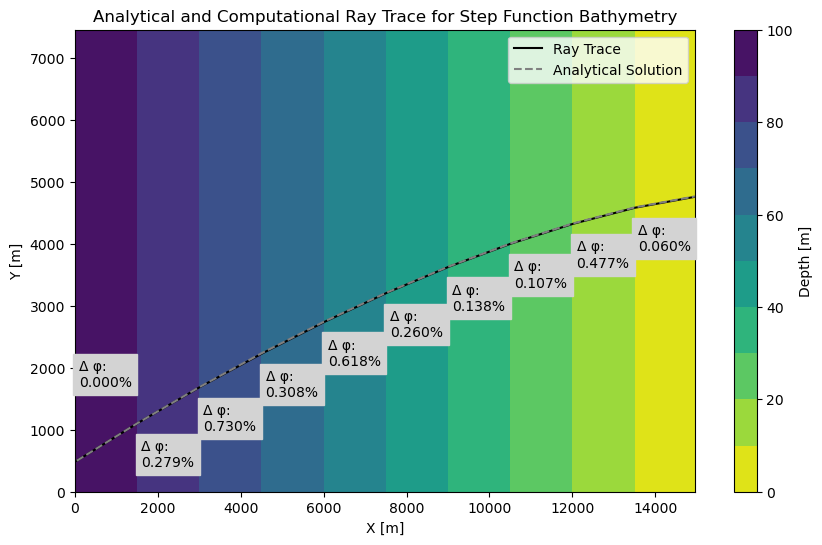

In [8]:
# Plot the Ray Comparisons
fig, ax = plt.subplots(figsize=(10,6))
contours = ax.contourf(step_bathymetry.x, step_bathymetry.y, step_bathymetry.depth, cmap='viridis_r', levels=np.flip(np.concatenate((depth_levels, np.array([0,])))))
ax.autoscale(False)
ax.plot(ray_evolution.x, ray_evolution.y, marker='', linestyle='solid', color='black', label='Ray Trace')
ax.plot(xs_analytical, ys_analytical, marker='', linestyle='dashed', color='grey', label='Analytical Solution')
for i, pcent_diff in enumerate(phi_diffs_percent):
    if i == 0:
        ax.text(x=mid_shelf_xs[i] - 650, y=ys_analytical[i]+1200, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
        continue
    ax.text(x=mid_shelf_xs[i] - 650, y=ys_analytical[i]-700, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
ax.legend()
ax.set_title(label='Analytical and Computational Ray Trace for Step Function Bathymetry')
ax.set_xlabel(xlabel='X [m]')
ax.set_ylabel(ylabel='Y [m]')
cax = fig.colorbar(contours, label='Depth [m]')

Snell's Law (For Bathymetry Only):

$\frac{sin(\phi_1)}{sin(\phi_2)} = \frac{c_1}{c_2} = \frac{|\vec{K_2}|}{|\vec{K_1}|}$

where the angles $\phi_1$ and $\phi_2$ are the incident and transmitted ray angles, $c_1$ and $c_2$ are the phase speeds of the wave before and after crossing the interface, and $\vec{K_1}$ and $\vec{K_2}$ are the wavenumbers of the incident and transmitted waves, respectively.

In the shallow water approximation, $c = \sqrt{g d}$, where g is the acceleration of gravity and d is the depth of the wave.

## Shear Current

### Import and Verify Data

Text(0.5, 1.0, 'V Current')

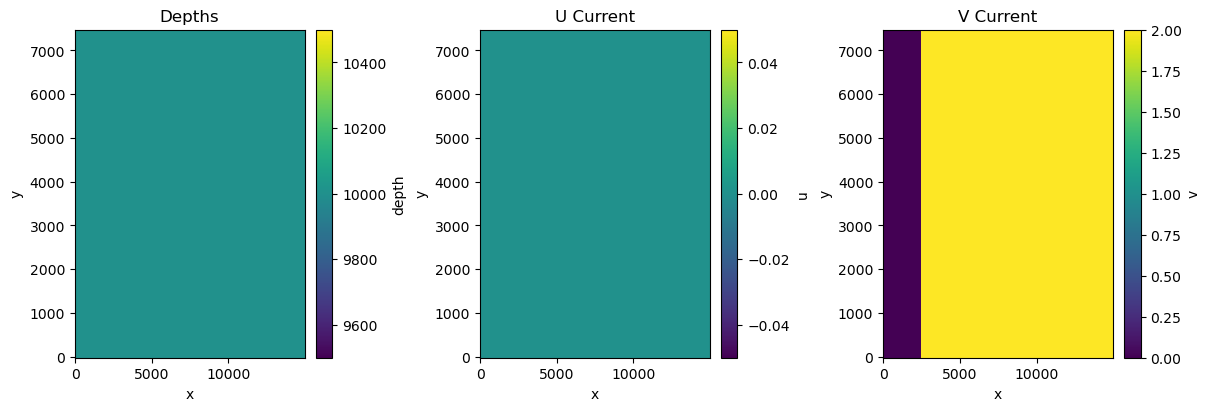

In [9]:
deep_flat_bathymetry_path = 'data/deep_water_flat_bathymetry.nc'
shear_current_path = 'data/shear_current_2v.nc'
deep_flat_bathymetry = xr.open_dataset(deep_flat_bathymetry_path)
shear_current = xr.open_dataset(shear_current_path)

# Plot Data to Verify
fig, ax_list = plt.subplots(1, 3, figsize=(12,4), layout='constrained')
deep_flat_bathymetry.depth.plot(ax=ax_list[0])
shear_current.u.plot(ax=ax_list[1])
shear_current.v.plot(ax=ax_list[2])
ax_list[0].set_title('Depths')
ax_list[1].set_title('U Current')
ax_list[2].set_title('V Current')

### Define Ray and Run Ray Trace

In [10]:
# Define Environment Parameters
v_currents_raw, v_current_indices = np.unique(shear_current.v.values, return_index=True)
v_currents = v_currents_raw # np.flip only works if currents decrease
v_current_indices = v_current_indices # np.flip only works if currents decrease
n_zones = len(v_currents)

# Define wave number
period = 10
lambda0 = 9.81*period**2/(2*np.pi)
k = 2*np.pi/lambda0 # lambda = 50m
phi0 = 50*np.pi/180 # phi0 = 25 degrees from x axis
kx = k*np.cos(phi0)
ky = k*np.sin(phi0)

# Define ray initial positon
x0 = 50 #Offset from 0 by 1 step
y0 = 500

In [11]:
ray_evolution_raw = single_ray(x0, y0, kx, ky, 40000, 1,
                           bathymetry='data/deep_water_flat_bathymetry.nc',
                           current='data/shear_current_2v.nc')
# Process ray trace dataset to add wavenumber magnitude and angle information
ray_evolution = ray_evolution_raw.assign(k = np.sqrt(ray_evolution_raw.kx**2 + ray_evolution_raw.ky**2),
                                         phi = np.arctan2(ray_evolution_raw.ky, ray_evolution_raw.kx))

### Analytically Solve for Ray Path

In [12]:
c0 = np.sqrt(9.8/k)

# Pick x values corresponding to the different boundaries
zone_edge_xs = shear_current.x.values[v_current_indices]
xs_analytical = np.append(zone_edge_xs, shear_current.x.values[-1]) #Add final right side boundary to xs_analytical
mid_zone_xs = zone_edge_xs + np.diff(xs_analytical)/2
xs_analytical[0] = 50

phis_analytical, ys_analytical, ks_analytical = analytical_ray_trace(xs_analytical, y0, phi0, k,
                                                                     mode='shear_currents', v_currents=v_currents)

c:\Users\james\Projects\SURF_2024\ray_tracing\notebooks\theoretical_comparison\supporting_functions.py:34: RuntimeWarning: overflow encountered in sinh
  n = 0.5 * (1 + 2*k*depth / np.sinh(2*k*depth))


### Compute Ray Trace Error and Plot Rays

In [13]:
# Organize computed ray angles with "x" as a coordinate
ray_angles = xr.DataArray(data=ray_evolution.phi.values[:-1], coords={'x':ray_evolution.x.values[:-1]})

# Find the difference and percent difference between the analytical and computational ray traces
phi_diffs = np.abs(phis_analytical - ray_angles.sel(x=mid_zone_xs, method='nearest'))
phi_diffs_percent = phi_diffs / phis_analytical * 100
print('Ray Trace Angle Absolute Difference from Theory:', phi_diffs.values*180/np.pi, 'degrees')
print('Ray Trace Angle Percent Difference from Theory:', phi_diffs_percent.values, '%')

Ray Trace Angle Absolute Difference from Theory: [0.         0.80306527] degrees
Ray Trace Angle Percent Difference from Theory: [0.        1.1411055] %


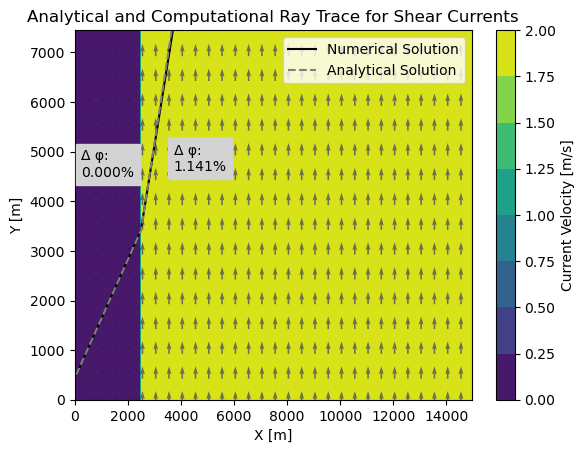

In [14]:
# Plot the Ray Comparisons
fig, ax = plt.subplots()
contours = ax.contourf(shear_current.x, shear_current.y, shear_current.v, cmap='viridis')
quiver_shear_currents = shear_current.sel(x=slice(10, None, 10), y=slice(10, None, 10))
ax.quiver(quiver_shear_currents.x, quiver_shear_currents.y, quiver_shear_currents.u, quiver_shear_currents.v, color='navy',
          pivot='middle', width=0.004, alpha=0.5)
ax.autoscale(False)
ax.plot(ray_evolution.x, ray_evolution.y, marker='', linestyle='solid', color='black', label='Numerical Solution')
ax.plot(xs_analytical, ys_analytical, marker='', linestyle='dashed', color='grey', label='Analytical Solution')
for i, pcent_diff in enumerate(phi_diffs_percent):
    if i == 0:
        ax.text(x=mid_zone_xs[i] - 1000, y=ys_analytical[i]+4000, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
        continue
    ax.text(x=mid_zone_xs[i]-5000, y=ys_analytical[i]+1200, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
ax.legend()
ax.set_title(label='Analytical and Computational Ray Trace for Shear Currents')
ax.set_xlabel(xlabel='X [m]')
ax.set_ylabel(ylabel='Y [m]')
cax = fig.colorbar(contours, label='Current Velocity [m/s]')

Snell's Law (For Shear Currents in Deep Water):

$sin(\phi _2) = \frac{sin(\phi _1)}{(1-\frac{V}{c_1} sin(\phi _1))^2}$

where the angles $\phi_1$ and $\phi_2$ are the incident and transmitted ray angles, $c_1$ is the phase speed of the wave before crossing the interface, and $V$ is the horizontally sheared current. 

In the deep water approximation, $c = \frac{g}{\omega _0} = \sqrt{\frac{g}{|\vec{K}|}}$, where $g$ is the acceleration of gravity, $\omega _0$ is the fundamental frequency of the wave, and $\vec{K}$ is the initial wavenumber.